Used Cars Dataset  
https://www.kaggle.com/datasets/austinreese/craigslist-carstrucks-data

In [1]:
import pandas as pd
import os
import json

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
def read_file(filename):
    return pd.read_csv(filename, compression='zip').drop(['url','region_url','image_url','description','VIN','lat','long'], axis=1)

In [4]:
def to_json(filename, data):
    with open(filename, 'w') as file:
        json.dump(data, file)

In [5]:
def get_memory_stat_by_column(df):
    memory_usage_stat = df.memory_usage(deep=True)
    total_memory_usage = memory_usage_stat.sum()
    print(f"file in memory size = {total_memory_usage // 1024} КБ")
    column_stat = list()
    for key in df.dtypes.keys():
        column_stat.append({
            "column_name": key,
            "memory_abs": int(memory_usage_stat[key] // 1024),
            "memory_per": float(round(memory_usage_stat[key] / total_memory_usage * 100, 4)),
            "dtype": str(df.dtypes[key])
        })
    column_stat.sort(key=lambda x: x['memory_abs'], reverse=True)
    cols = list(column_stat[0].keys())
    print(f"{cols[0]:30}: {cols[1]:10} КБ: {cols[2]:10}% : {cols[3]}") #заголовки для таблицы 
    for column in column_stat:
        print(
            f"{column['column_name']:30}: {column['memory_abs']:10} КБ: {column['memory_per']:10}% : {column['dtype']}")

    return column_stat


In [6]:
# ф-ии для оптимизации
def mem_usage(pandas_obj):
    '''функция для расчета занимаемого объема в памяти в КБ'''
    if isinstance(pandas_obj, pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else:  # предположим, что если это не датафрейм, то серия
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_kb = usage_b / 1024   # преобразуем байты в мегабайты
    return "{:03.2f} KB".format(usage_kb)

def opt_obj(df):
    '''функция для преобразования столбцов из типа object в category'''
    converted_obj = pd.DataFrame()
    dataset_obj = df.select_dtypes(include=['object']).copy()

    for col in dataset_obj.columns:
        num_unique_values = len(dataset_obj[col].unique())
        num_total_values = len(dataset_obj[col])
        if num_unique_values / num_total_values < 0.5:
            converted_obj.loc[:, col] = dataset_obj[col].astype('category')
        else:
            converted_obj.loc[:, col] = dataset_obj[col]

    print('\nПреобразование колонок из типа object в category')
    print(f'Первоначальный датасет: {mem_usage(dataset_obj)}')
    print(f'Преобразованный датасет: {mem_usage(converted_obj)}')
    return converted_obj


def opt_int(df):
    '''понижающее преобразование типов «int» колонок '''
    dataset_int = df.select_dtypes(include=['int'])
    """
    downcast:
            - 'integer' or 'signed': smallest signed int dtype (min.: np.int8)
            - 'unsigned': smallest unsigned int dtype (min.: np.uint8)
            - 'float': smallest float dtype (min.: np.float32)
    """
    converted_int = dataset_int.apply(pd.to_numeric, downcast='unsigned')
    print('\nПреобразование колонок типа int')
    print(f'Первоначальный датасет: {mem_usage(dataset_int)}')
    print(f'Преобразованный датасет: {mem_usage(converted_int)}')
    #
    compare_ints = pd.concat([dataset_int.dtypes, converted_int.dtypes], axis=1)
    compare_ints.columns = ['before', 'after']
    compare_ints.apply(pd.Series.value_counts)
    print(compare_ints)

    return converted_int


def opt_float(df):
    '''понижающее преобразование типов «float» колонок '''
    # # =======================================================================
    # # выполняем понижающее преобразование
    # # для столбцов типа float
    dataset_float = df.select_dtypes(include=['float'])
    converted_float = dataset_float.apply(pd.to_numeric, downcast='float')

    print('\nПреобразование колонок типа float')
    print(f'Первоначальный датасет: {mem_usage(dataset_float)}')
    print(f'Преобразованный датасет: {mem_usage(converted_float)}')

    compare_floats = pd.concat([dataset_float.dtypes, converted_float.dtypes], axis=1)
    compare_floats.columns = ['before', 'after']
    compare_floats.apply(pd.Series.value_counts)
    print(compare_floats)

    return converted_float

In [7]:
# step 1: чтение файла
df = read_file('archive.zip')

In [8]:
# step 2-3
# место занимаемое на диске
print(f'file size (in .zip format) is {os.path.getsize("archive.zip") // 1024} KB')

# объем датасета в памяти, объем для колонок, сортировка колонок по объему, экспорт в json
to_json('outputs/column_stat_unopt.json', get_memory_stat_by_column(df))

file size (in .zip format) is 268786 KB
file in memory size = 362584 КБ
column_name                   : memory_abs КБ: memory_per% : dtype
posting_date                  :      33763 КБ:     9.3119% : object
model                         :      28543 КБ:     7.8723% : object
region                        :      28532 КБ:     7.8693% : object
transmission                  :      27110 КБ:      7.477% : object
manufacturer                  :      25646 КБ:     7.0733% : object
title_status                  :      25627 КБ:      7.068% : object
fuel                          :      25101 КБ:      6.923% : object
state                         :      24595 КБ:     6.7834% : object
type                          :      23125 КБ:     6.3779% : object
cylinders                     :      22095 КБ:     6.0938% : object
paint_color                   :      21971 КБ:     6.0596% : object
drive                         :      21442 КБ:     5.9137% : object
condition                     :      21077 КБ

In [9]:
# step 4-6
conv_obj = opt_obj(df)
conv_int = opt_int(df)
conv_float = opt_float(df)


Преобразование колонок из типа object в category
Первоначальный датасет: 345909.43 KB
Преобразованный датасет: 43256.71 KB

Преобразование колонок типа int
Первоначальный датасет: 6670.12 KB
Преобразованный датасет: 5002.62 KB
      before   after
id     int64  uint64
price  int64  uint32

Преобразование колонок типа float
Первоначальный датасет: 10005.12 KB
Преобразованный датасет: 5002.62 KB
           before    after
year      float64  float32
odometer  float64  float32
county    float64  float32


In [10]:
# собираем оптимизированный датасет
optimized_dataset = df.copy()
optimized_dataset[conv_obj.columns] = conv_obj
optimized_dataset[conv_int.columns] = conv_int
optimized_dataset[conv_float.columns] = conv_float

In [11]:
# step 7: повторный анализ занимаемой памяти
to_json('outputs/column_stat_opt.json', get_memory_stat_by_column(optimized_dataset))

file in memory size = 53261 КБ
column_name                   : memory_abs КБ: memory_per% : dtype
posting_date                  :      33763 КБ:    63.3919% : object
model                         :       4015 КБ:       7.54% : category
id                            :       3335 КБ:     6.2615% : uint64
price                         :       1667 КБ:     3.1308% : uint32
year                          :       1667 КБ:     3.1308% : float32
odometer                      :       1667 КБ:     3.1308% : float32
county                        :       1667 КБ:     3.1308% : float32
region                        :        877 КБ:     1.6466% : category
state                         :        421 КБ:     0.7921% : category
manufacturer                  :        420 КБ:     0.7895% : category
type                          :        418 КБ:     0.7852% : category
condition                     :        417 КБ:     0.7837% : category
cylinders                     :        417 КБ:     0.7842% : category
f

In [21]:
# step 8: отбор столбцов
# необходимые столбцы
column_names = ['region', 'price', 'year',
                 'manufacturer', 'model', 'condition',
                 'transmission', 'state', 'cylinders', 'fuel']
# типы данных
opt_dtypes = optimized_dataset.dtypes

# формируем словарь столбец:тип
need_column = dict()
for key in df.columns:
    need_column[key] = opt_dtypes[key]
    print(f"{key}:{opt_dtypes[key]}")

# записываем в json
with open("outputs/dtypes_2.json", mode="w") as file:
    dtype_json = need_column.copy()
    for key in dtype_json.keys():
        dtype_json[key] = str(dtype_json[key])

    json.dump(dtype_json, file)

id:uint64
region:category
price:uint32
year:float32
manufacturer:category
model:category
condition:category
cylinders:category
fuel:category
odometer:float32
title_status:category
transmission:category
drive:category
size:category
type:category
paint_color:category
county:float32
state:category
posting_date:object


In [13]:
# автоматическая оптимизированная загрузка датафрейма с отобранными столбцами
cars = pd.read_csv('archive.zip', compression='zip', usecols=column_names, dtype=need_column)

In [14]:
# step9: графики

<Figure size 1600x2500 with 0 Axes>

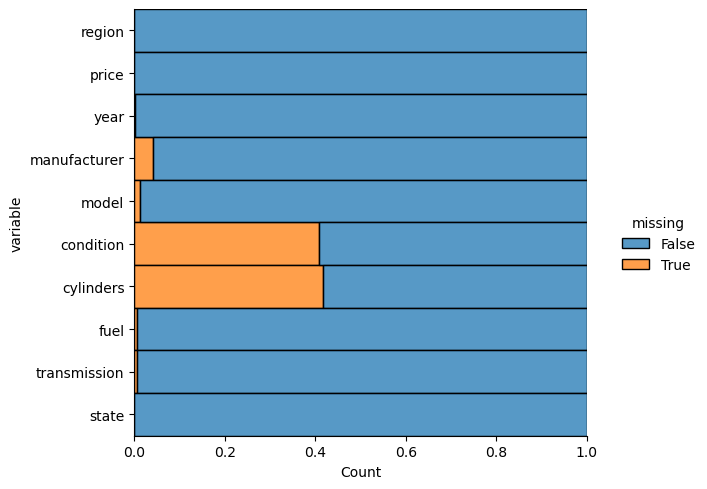

In [15]:
# визуализация количества пропусков в данных
plt.figure(figsize=(16,25))
sns.displot(
    data=cars.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.25
)

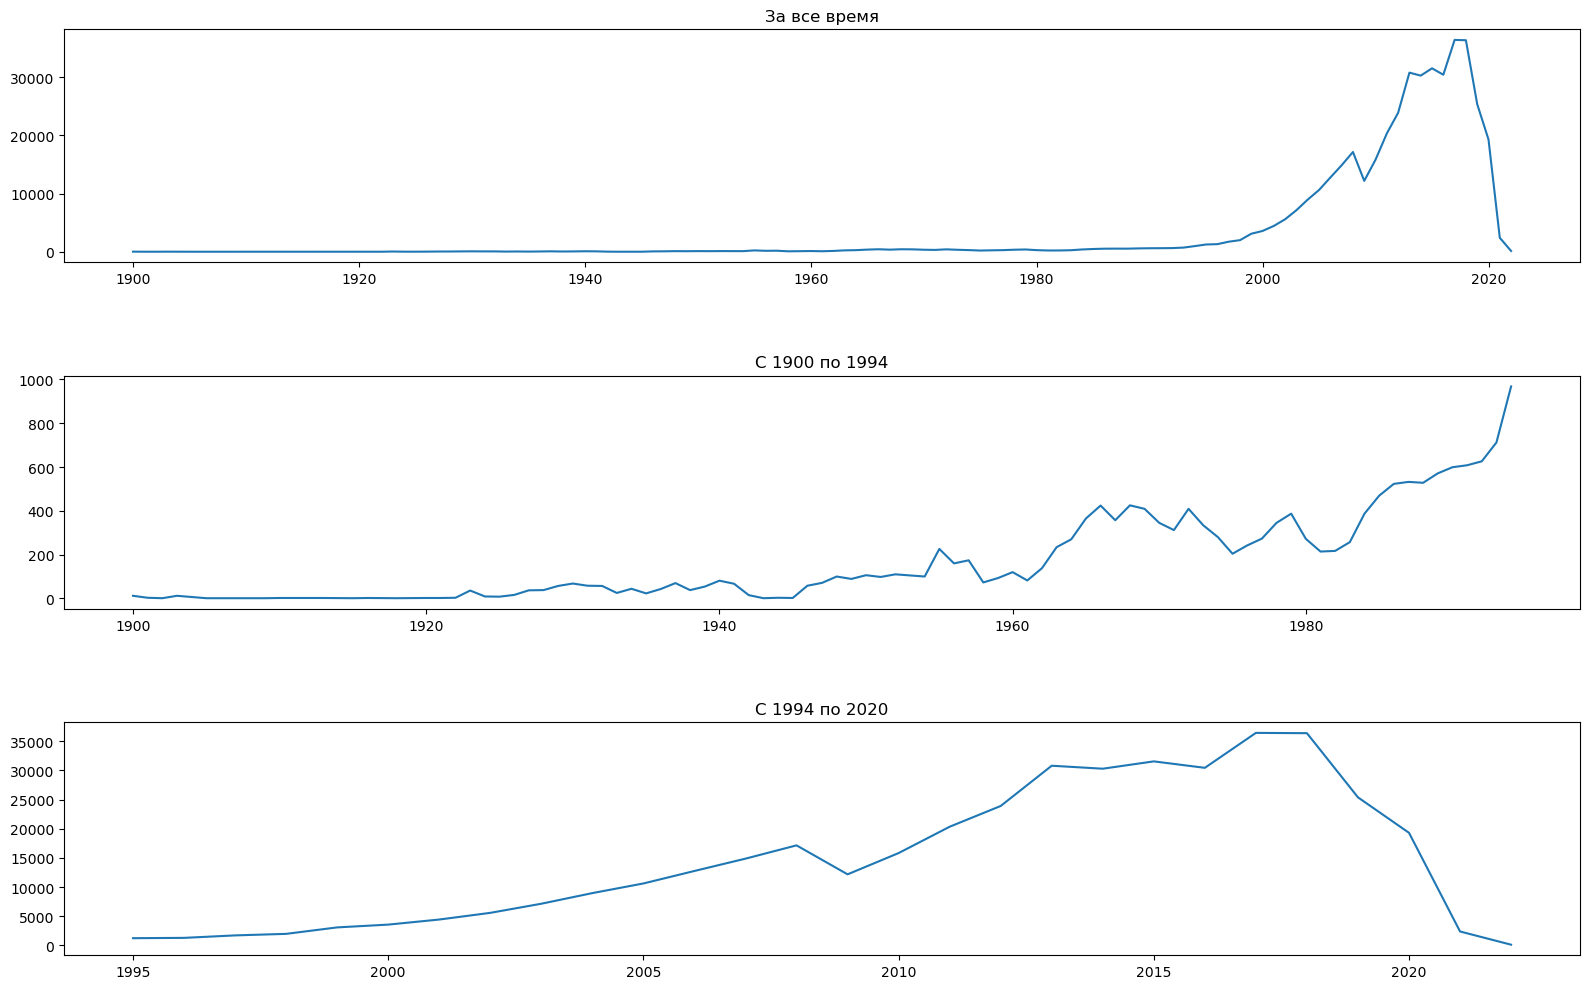

In [16]:
# Количество объявлений о продаже автомобилей по годам. Так как с 1900 по ~2000 год машин продавалось гораздо меньше, чем в 21 веке,
# дополнительно график разделен на эти две части
by_year = cars[['price','year']].groupby(['year']).count()

fig, axs = plt.subplots(3, 1, figsize=(16, 10))
axs[0].plot(by_year)
axs[0].title.set_text('За все время')
axs[1].plot(by_year[by_year.index < 1995])
axs[1].title.set_text('С 1900 по 1994')
axs[2].plot(by_year[by_year.index >= 1995])
axs[2].title.set_text('С 1994 по 2020')

plt.tight_layout(pad=1.08, h_pad=5, w_pad=0)

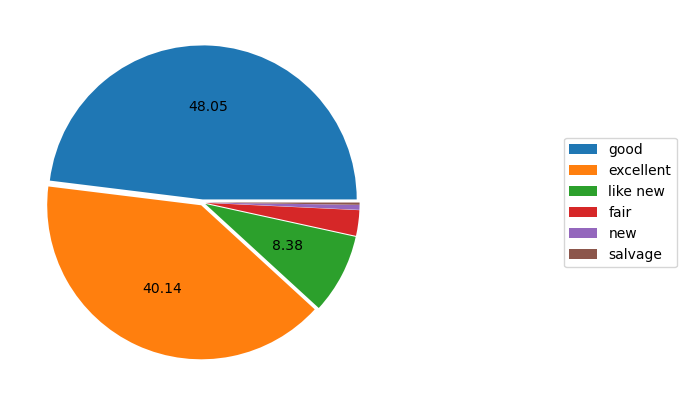

In [17]:
# круговая диаграмма со статистикой по полю condition
man = cars['condition'].value_counts()

def my_autopct(pct):
    return ('%.2f' % pct) if pct > 5 else ''

plt.figure(figsize=(5,5))

plt.pie(man.values, autopct=my_autopct,
        labels = [' ' for i in range(len(man))],
        explode = [0.02 for i in range(len(man))])

plt.legend(labels=man.index, loc='center right', bbox_to_anchor=(1.75, 0.5))
plt.show()

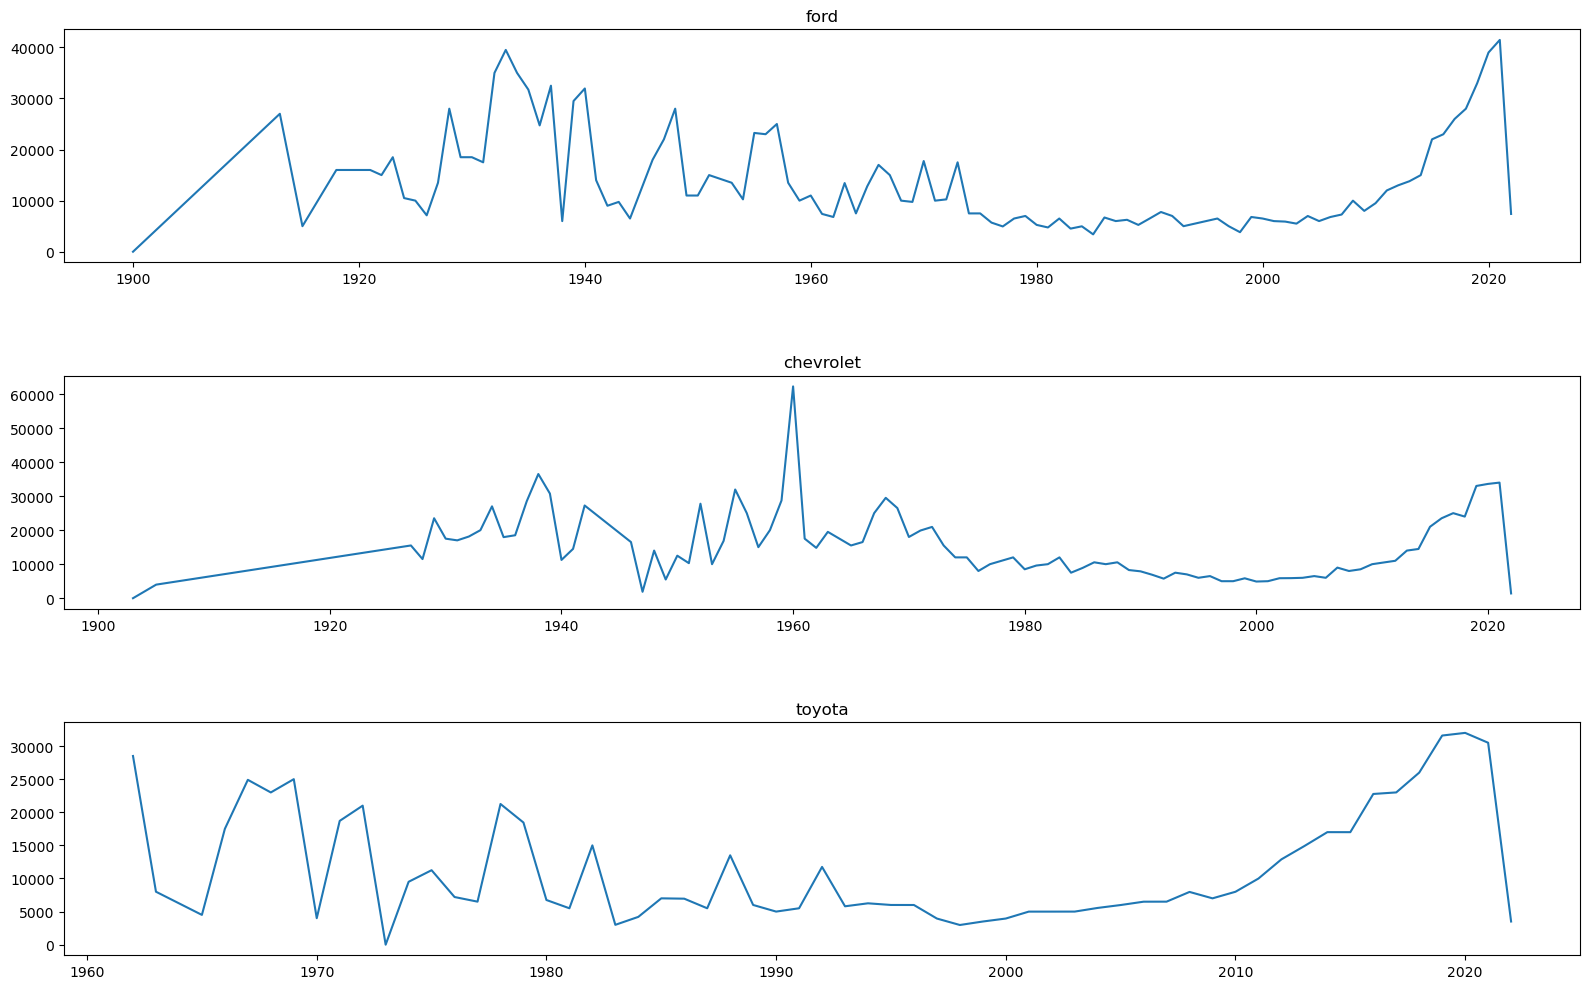

In [18]:
# динамика цен по 3 наиболее распространенным маркам авто
# определяем марки с наибольшим количеством записей
top_man = list(cars['manufacturer'].value_counts()[:3].index)

# оставляем выбранные марки, по группе марка-год считаем медиану
tmp = cars[['year','manufacturer','price']][cars['manufacturer'].isin(top_man)].groupby(['manufacturer','year'], observed=True).median().reset_index()

fig, axs = plt.subplots(3, 1, figsize=(16, 10))
for man in top_man:
    axs[top_man.index(man)].plot(tmp[tmp['manufacturer'] == man].set_index('year')['price'])
    axs[top_man.index(man)].title.set_text(man)

plt.tight_layout(pad=1.08, h_pad=5, w_pad=0)

<Axes: title={'center': 'fuel'}, xlabel='fuel'>

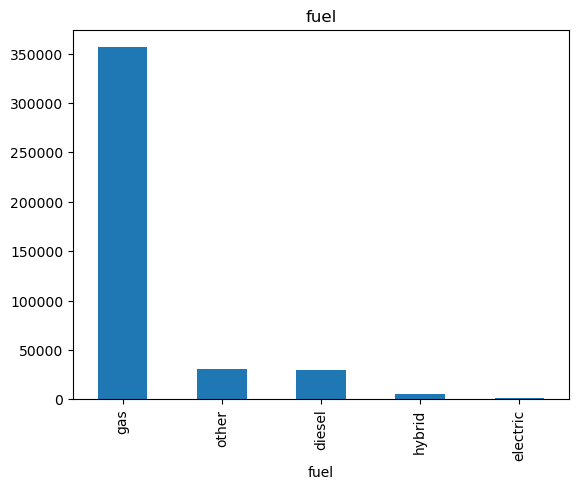

In [19]:
# распределение машин по потребляемому топливу
cars['fuel'].value_counts().plot(kind='bar', title='fuel')

<Axes: title={'center': 'fuel'}, xlabel='cylinders'>

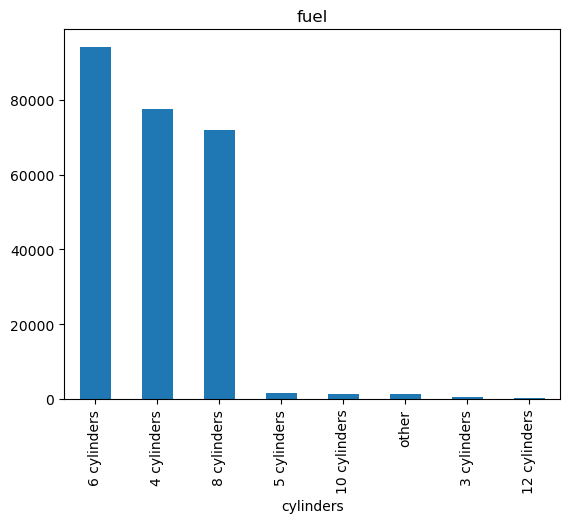

In [20]:
# распределение машин по количеству цилиндров в двигателе
cars['cylinders'].value_counts().plot(kind='bar', title='fuel')